The dataset contains images of 3 types.

Classes:-
- fire
- smoke
- non fire

# Reading & Understanding Data
## Importing Libraries

In [1]:
# importing libraries
import os, time, random, sys
os.environ['PYTHONHASHSEED']=str(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('seaborn-deep')
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.figsize'] = (12, 8)

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 400)
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import sklearn.utils as sku
from skimage.io import imread
from skimage.transform import resize
seed = 12

/tmp/ipykernel_30/1243691865.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-deep')


In [2]:
import tensorflow as tf
# import tensorflow_addons as tfa
print("TF version:-", tf.__version__)
import tensorflow.keras as k
import keras
from keras import backend as K

from keras.layers import TFSMLayer

import warnings
warnings.filterwarnings("ignore")

TF version:- 2.16.1


In [3]:
def runSeed():
    global seed
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

runSeed()

## Checking the GPU configuration
##!nvidia-smi

### Loading Dataset

In [4]:
basePath = '/kaggle/input/forest-fire-and-non-fire-dataset/'
trainPath = basePath + 'train'
testPath = basePath + 'test'
os.listdir(trainPath)

['Smoke', 'non fire', 'fire']

In [5]:
def showImage(img):
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.show()

# Data Preparation


## Setup Image Generator

In [6]:
# constants
batch_size = 128
img_dim = 299
def getImgTensor(img_d):
    return (img_d, img_d, 3)
getImgTensor(img_dim)

(299, 299, 3)

In [7]:
# reading training and validation separately to prevent overlapping 

train_datagen = k.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                         validation_split=0.2,
                                                         shear_range=0.2, 
                                                         zoom_range=0.2, 
                                                         horizontal_flip=True, 
                                                         rotation_range=45,
                                                         width_shift_range=0.1, 
                                                         height_shift_range=0.1,
                                                         fill_mode='nearest'
                                                        )

train_generator=train_datagen.flow_from_directory(directory=trainPath,
                                                  subset="training",
                                                  batch_size=batch_size,
                                                  color_mode="rgb",
                                                  seed=seed,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=getImgTensor(img_dim)[:2])

Found 25919 images belonging to 3 classes.


In [8]:
# generate class weights as classes are imbalanced
class_weights = sku.class_weight.compute_class_weight(class_weight = 'balanced',
                                                      classes = np.unique(train_generator.classes), 
                                                      y = train_generator.classes)
train_class_weights = {i:x for i, x in enumerate(class_weights)}
train_class_weights

{0: 0.9999614197530864, 1: 1.0000771694254735, 2: 0.9999614197530864}

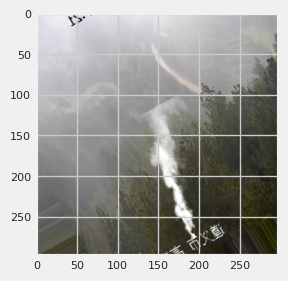

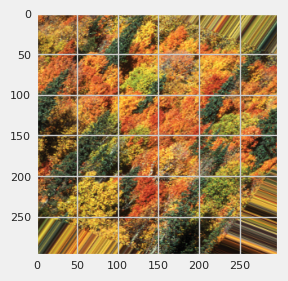

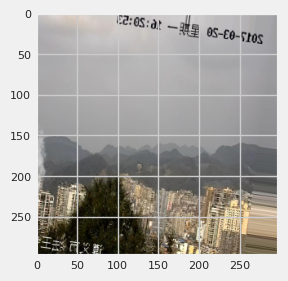

In [9]:
batch = next(train_generator)[0]
showImage(batch[0])
showImage(batch[1])
showImage(batch[2])

In [10]:
valid_generator=train_datagen.flow_from_directory(directory=trainPath,
                                                  subset="validation",
                                                  batch_size=batch_size,
                                                  color_mode="rgb",
                                                  seed=seed,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=getImgTensor(img_dim)[:2])

Found 6479 images belonging to 3 classes.


In [11]:
test_datagen = k.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_directory(testPath, 
                                                batch_size=1,
                                                color_mode="rgb",
                                                seed=seed,
                                                shuffle=False,
                                                classes=['Smoke','fire', 'non fire'],
                                                target_size=getImgTensor(img_dim)[:2])

Found 10500 images belonging to 3 classes.


# Model Building

In [12]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 4, figsize=(15, 4))
    print("h.history: ", h.history)
    
    # Plot loss
    ax[0].plot(h.history['loss'])
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss', 'val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")
    
    # Plot accuracy (categorical_accuracy)
    ax[1].plot(h.history['categorical_accuracy'])
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy', 'val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    
    # Dynamically detect the recall key names
    recall_key = [key for key in h.history.keys() if "recall" in key and not "val" in key][0]
    val_recall_key = [key for key in h.history.keys() if "recall" in key and "val" in key][0]
    
    ax[2].plot(h.history[recall_key])
    ax[2].plot(h.history[val_recall_key])
    ax[2].legend([recall_key, val_recall_key])
    ax[2].title.set_text("Train recall vs Validation recall")
    
    # Dynamically detect the precision key names
    precision_key = [key for key in h.history.keys() if "precision" in key and not "val" in key][0]
    val_precision_key = [key for key in h.history.keys() if "precision" in key and "val" in key][0]
    
    ax[3].plot(h.history[precision_key])
    ax[3].plot(h.history[val_precision_key])
    ax[3].legend([precision_key, val_precision_key])
    ax[3].title.set_text("Train precision vs Validation precision")

    # Print the maximum values for the metrics
    print("Max. Training Accuracy:", max(h.history['categorical_accuracy']))
    print("Max. Validation Accuracy:", max(h.history['val_categorical_accuracy']))
    print(f"Max. Training Recall ({recall_key}):", max(h.history[recall_key]))
    print(f"Max. Validation Recall ({val_recall_key}):", max(h.history[val_recall_key]))
    print(f"Max. Training Precision ({precision_key}):", max(h.history[precision_key]))
    print(f"Max. Validation Precision ({val_precision_key}):", max(h.history[val_precision_key]))

In [13]:
class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        ACCURACY_THRESHOLD = 0.99
        if(logs.get('categorical_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

In [14]:
def trainModel(model, epochs, optimizer, vb=1, modelName='model'):
    bestModelPath = './'+modelName+'_model.keras'
    callback = myCallback()
    callbacks_list = [
        callback,
        k.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, min_lr=0.00001), 
        k.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15, verbose = 1, restore_best_weights = True), 
        k.callbacks.ModelCheckpoint(filepath=bestModelPath, monitor='val_loss', verbose=1, save_best_only=True)
    ]
    model.compile(optimizer=optimizer,
                  loss=k.losses.CategoricalCrossentropy(label_smoothing=.05),
                  metrics=[k.metrics.CategoricalAccuracy(), k.metrics.Recall(), k.metrics.Precision()]
    )
    train_generator.reset()
    
    steps_per_epoch = int(np.ceil(train_generator.n/train_generator.batch_size))
    validation_steps = int(np.ceil(valid_generator.n/valid_generator.batch_size))

    return model.fit(train_generator, # steps_per_epoch=steps_per_epoch, 
                               validation_data=valid_generator, # validation_steps=validation_steps, 
                               epochs=epochs, verbose=vb,
                              #  class_weight=train_class_weights,
                               callbacks=callbacks_list)

In [17]:
# evaluate model with time
def evaluateModel(model, path=True):
    batch_size = valid_generator.batch_size
    num_train_sequences = valid_generator.n
    valid_generator.reset()
    steps_per_epoch = 0
    if (valid_generator.n%valid_generator.batch_size) == 0:
        steps_per_epoch = int(valid_generator.n/valid_generator.batch_size)
    else:
        steps_per_epoch = int(valid_generator.n//valid_generator.batch_size) + 1

    t1 = time.time()
    if path:
        model = k.models.load_model(model)
    eval_results = model.evaluate(valid_generator, steps=steps_per_epoch)
    t2 = time.time()
    print(f'\nLoss: {eval_results[0]}, Accuracy: {eval_results[1]}')
    print(f'\nPrecision: {eval_results[2]}, Recall: {eval_results[3]}')
    print(f'Prediction Time per Image: {(t2-t1)/valid_generator.n}')

In [82]:
# evaluate model with time
def evaluateModelWithTestData(model, path=True):
    batch_size = test_generator.batch_size
    num_train_sequences = test_generator.n
    steps_per_epoch = 0
    if (test_generator.n%test_generator.batch_size) == 0:
        steps_per_epoch = int(test_generator.n/test_generator.batch_size)
    else:
        steps_per_epoch = int(test_generator.n//test_generator.batch_size) + 1

    test_generator.reset()

    t1 = time.time()
    if path:
        model = k.models.load_model(model)
    eval_results = model.evaluate(test_generator, steps=steps_per_epoch)
    t2 = time.time()
    print(f'\nLoss: {eval_results[0]}, Accuracy: {eval_results[1]}')
    print(f'\nPrecision: {eval_results[2]}, Recall: {eval_results[3]}')
    print(f'Prediction Time per Image: {(t2-t1)/test_generator.n}')

## Train MobileNetV2 - Light Model

In [41]:
img_dim=299
mobilenet = k.applications.mobilenet_v2.MobileNetV2(weights='imagenet', input_shape=getImgTensor(img_dim), include_top=False)
mobilenet.trainable = False

model = k.models.Sequential([
                             mobilenet,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             k.layers.Dropout(0.4),
                             k.layers.Dense(256, activation='relu'),
                            #  k.layers.BatchNormalization(),
                             k.layers.Dropout(0.3),
                             k.layers.Dense(128, activation='relu'),
#                              k.layers.BatchNormalization(),
                             k.layers.Dropout(0.2),
                             k.layers.Dense(3, activation='softmax')
])
print(model.summary())

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [42]:
history_1 = trainModel(model, 10, 'adam', modelName='mobilenet')

Epoch 1/10


I0000 00:00:1727342270.595715     221 service.cc:145] XLA service 0x785518011420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727342270.595785     221 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727342270.595788     221 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-09-26 09:17:58.884764: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[128,32,150,150]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,32,150,150]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-26 09:17:58.952352:

  1/203 ━━━━━━━━━━━━━━━━━━━━ 3:44:16 67s/step - categorical_accuracy: 0.2969 - loss: 1.4082 - precision: 0.3053 - recall: 0.2266

I0000 00:00:1727342296.890789     221 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.8084 - loss: 0.5659 - precision: 0.8425 - recall: 0.7628

2024-09-26 09:36:21.257941: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[79,96,75,75]{3,2,1,0}, u8[0]{0}) custom-call(f32[79,96,151,151]{3,2,1,0}, f32[96,1,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-26 09:36:21.310538: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.052694721s
Trying algorithm eng4{} for conv (f32[79,96,75,75]{3,2,1,0}, u8[0]{0}) custom-call(f32[79,96,151,151]{3,2,1,0}, f32[96,1,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_opera


Epoch 1: val_loss improved from inf to 0.34193, saving model to ./mobilenet_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 1158s 5s/step - categorical_accuracy: 0.8088 - loss: 0.5653 - precision: 0.8429 - recall: 0.7633 - val_categorical_accuracy: 0.9316 - val_loss: 0.3419 - val_precision: 0.9444 - val_recall: 0.9174 - learning_rate: 0.0010
Epoch 2/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9350 - loss: 0.3420 - precision: 0.9466 - recall: 0.9213
Epoch 2: val_loss improved from 0.34193 to 0.31902, saving model to ./mobilenet_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 814s 4s/step - categorical_accuracy: 0.9350 - loss: 0.3420 - precision: 0.9466 - recall: 0.9213 - val_categorical_accuracy: 0.9378 - val_loss: 0.3190 - val_precision: 0.9506 - val_recall: 0.9299 - learning_rate: 0.0010
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9479 - loss: 0.3134 - precision: 0.9582 - recall: 0.9381
Epoch 3: val_loss improved from 0.31902 to 0.31729, sa

h.history:  {'categorical_accuracy': [0.8867626190185547, 0.9399667978286743, 0.9472973346710205, 0.9542034864425659, 0.9537791013717651, 0.9567884802818298, 0.9591805338859558, 0.9600679278373718, 0.9631544351577759, 0.9629615545272827], 'loss': [0.43017661571502686, 0.3305317759513855, 0.31228044629096985, 0.2969626486301422, 0.2925731837749481, 0.2854136526584625, 0.27953702211380005, 0.2762955129146576, 0.26931214332580566, 0.27015700936317444], 'precision': [0.9109737873077393, 0.9520887136459351, 0.9575499296188354, 0.9617303609848022, 0.9615550637245178, 0.9645376205444336, 0.966451108455658, 0.9665623903274536, 0.9690878391265869, 0.9681598544120789], 'recall': [0.8586751222610474, 0.9276978373527527, 0.937304675579071, 0.9443651437759399, 0.9456769227981567, 0.9496893882751465, 0.9513869881629944, 0.9535475969314575, 0.9579458832740784, 0.95728999376297], 'val_categorical_accuracy': [0.931625247001648, 0.9377990365028381, 0.9385707378387451, 0.9425837397575378, 0.9470597505569

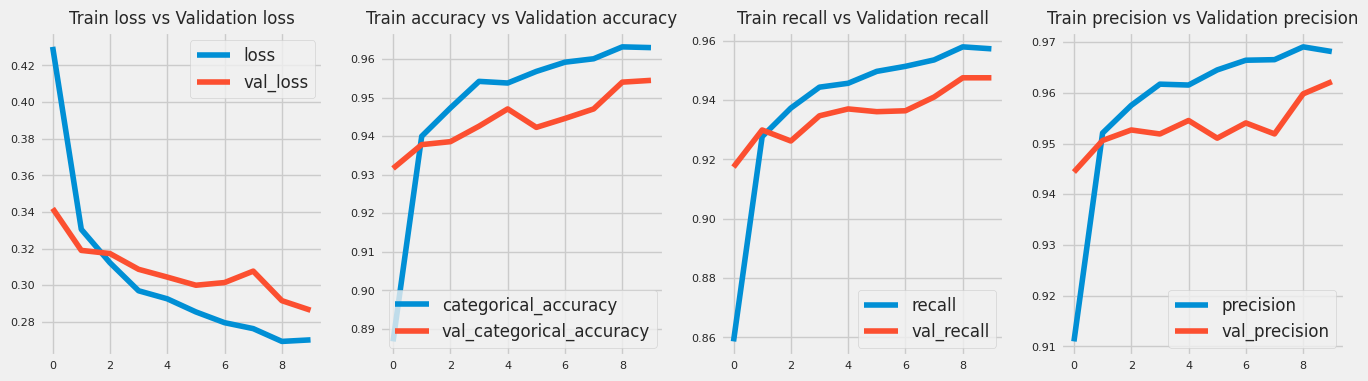

In [43]:
plotModelHistory(history_1)

## Train ResNet152 - Heavy Model

In [17]:
img_dim=299
resnet152 = k.applications.ResNet152V2(weights='imagenet', input_shape=getImgTensor(img_dim), include_top=False)
resnet152.trainable = False

model_2 = k.models.Sequential([
                             resnet152,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             k.layers.Dropout(0.4),
                            #  k.layers.Dense(1024, activation='relu'),
                            #  k.layers.BatchNormalization(),
                            #  k.layers.Dropout(0.3),

                             k.layers.Dense(512, activation='relu'),
                             k.layers.BatchNormalization(),
                             k.layers.Dropout(0.3),

                             k.layers.Dense(256, activation='relu'),
                             k.layers.BatchNormalization(),
                             k.layers.Dropout(0.3),
                             k.layers.Dense(3, activation='softmax')
])
print(model_2.summary())

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ ?                      │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,331,648 (222.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,331,648 (222.52 MB)

None


In [ ]:
history_2 = trainModel(model_2, 10, 'adam', modelName='resnet152')

Epoch 1/10


I0000 00:00:1727264061.346820     133 service.cc:145] XLA service 0x7eb170001f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727264061.346885     133 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727264061.346891     133 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1727264100.625956     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.8595 - loss: 0.5525 - precision: 0.8720 - recall: 0.8474
Epoch 1: val_loss improved from inf to 0.32501, saving model to ./resnet152_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 1329s 6s/step - categorical_accuracy: 0.8598 - loss: 0.5518 - precision: 0.8722 - recall: 0.8476 - val_categorical_accuracy: 0.9373 - val_loss: 0.3250 - val_precision: 0.9440 - val_recall: 0.9310 - learning_rate: 0.0010
Epoch 2/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9469 - loss: 0.3153 - precision: 0.9543 - recall: 0.9371
Epoch 2: val_loss improved from 0.32501 to 0.31325, saving model to ./resnet152_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 891s 4s/step - categorical_accuracy: 0.9469 - loss: 0.3153 - precision: 0.9543 - recall: 0.9371 - val_categorical_accuracy: 0.9427 - val_loss: 0.3132 - val_precision: 0.9485 - val_recall: 0.9383 - learning_rate: 0.0010
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_a

h.history:  {'categorical_accuracy': [0.9047031402587891, 0.9466414451599121, 0.9543192386627197, 0.9603379964828491, 0.9622284770011902, 0.9651992917060852, 0.96473628282547, 0.9670512080192566, 0.9679771661758423, 0.9713337421417236], 'loss': [0.42553767561912537, 0.31346210837364197, 0.29147133231163025, 0.27738067507743835, 0.2705494463443756, 0.2630438804626465, 0.2627424895763397, 0.25651124119758606, 0.2539038062095642, 0.24755427241325378], 'precision': [0.9147794246673584, 0.9543615579605103, 0.9600187540054321, 0.9656587243080139, 0.9672777056694031, 0.9688788652420044, 0.9689898490905762, 0.9710415601730347, 0.9718397259712219, 0.974916398525238], 'recall': [0.8945561051368713, 0.937497615814209, 0.9467957615852356, 0.9536247253417969, 0.9568656086921692, 0.9609166979789734, 0.9596434831619263, 0.9625371098518372, 0.9640032649040222, 0.9672055244445801], 'val_categorical_accuracy': [0.9373360276222229, 0.9427380561828613, 0.9453619122505188, 0.9526161551475525, 0.95138138532

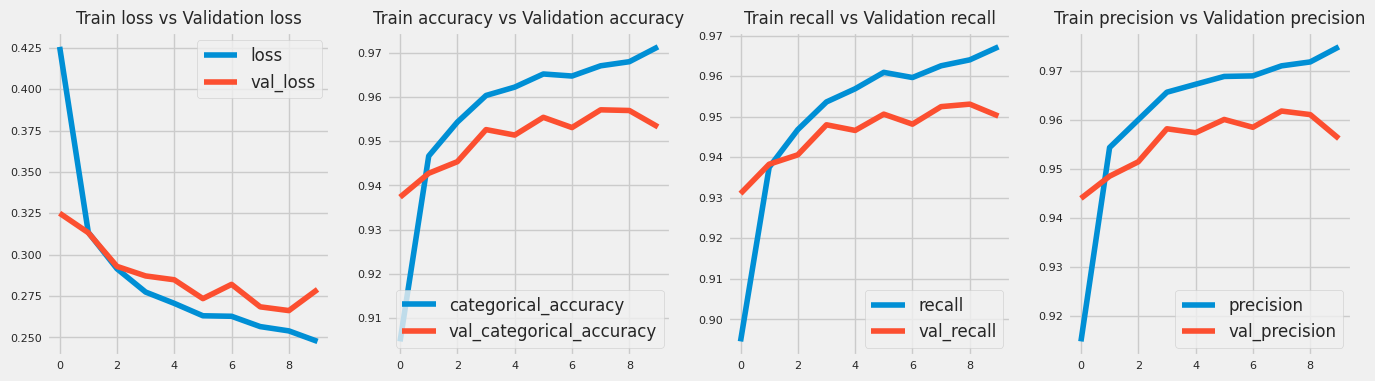

In [29]:
plotModelHistory(history_2)

## Train InceptionV3 - Medium Model

In [20]:
img_dim=299
inceptionv3 = k.applications.InceptionV3(weights='imagenet', input_shape=getImgTensor(img_dim), include_top=False)
inceptionv3.trainable = False

model_3 = k.models.Sequential([
                             inceptionv3,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             k.layers.Dropout(0.4),
                             k.layers.Dense(256, activation='relu'),
                             k.layers.BatchNormalization(),
                             k.layers.Dropout(0.3),
                            #  k.layers.Dense(128, activation='relu'),
                            #  k.layers.BatchNormalization(),
                            #  k.layers.Dropout(0.2),
                             k.layers.Dense(3, activation='softmax')
])
print(model_3.summary())

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

None


In [21]:
history_3 = trainModel(model_3, 10, 'adam', modelName='inceptionv3')

Epoch 1/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.8746 - loss: 0.5057 - precision_1: 0.8839 - recall_1: 0.8642
Epoch 1: val_loss improved from inf to 0.34408, saving model to ./inceptionv3_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 919s 4s/step - categorical_accuracy: 0.8748 - loss: 0.5052 - precision_1: 0.8841 - recall_1: 0.8644 - val_categorical_accuracy: 0.9279 - val_loss: 0.3441 - val_precision_1: 0.9398 - val_recall_1: 0.9157 - learning_rate: 0.0010
Epoch 2/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9366 - loss: 0.3320 - precision_1: 0.9451 - recall_1: 0.9269
Epoch 2: val_loss improved from 0.34408 to 0.34265, saving model to ./inceptionv3_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 853s 4s/step - categorical_accuracy: 0.9367 - loss: 0.3320 - precision_1: 0.9451 - recall_1: 0.9270 - val_categorical_accuracy: 0.9265 - val_loss: 0.3427 - val_precision_1: 0.9376 - val_recall_1: 0.9139 - learning_rate: 0.0010
Epoch 3/10
203/203 ━━━━━━━━━

h.history:  {'categorical_accuracy': [0.9124966263771057, 0.9412400126457214, 0.94833904504776, 0.9523515701293945, 0.9544349908828735, 0.954589307308197, 0.9567884802818298, 0.9572514295578003, 0.960260808467865, 0.9589490294456482], 'loss': [0.40148839354515076, 0.3233783543109894, 0.30585649609565735, 0.2987203299999237, 0.2912534773349762, 0.2889130115509033, 0.2856510281562805, 0.28323668241500854, 0.278776615858078, 0.277882844209671], 'precision_1': [0.9219735264778137, 0.9492924809455872, 0.9564636945724487, 0.9604663848876953, 0.9622730016708374, 0.9622560143470764, 0.9632399082183838, 0.9643779993057251, 0.96620112657547, 0.9658233523368835], 'recall_1': [0.9026582837104797, 0.9317489266395569, 0.9400054216384888, 0.9439021348953247, 0.9466800689697266, 0.9472202062606812, 0.9493036270141602, 0.9504996538162231, 0.9529302716255188, 0.9529302716255188], 'val_categorical_accuracy': [0.9279209971427917, 0.9265318512916565, 0.9374903440475464, 0.9439728260040283, 0.94474458694458

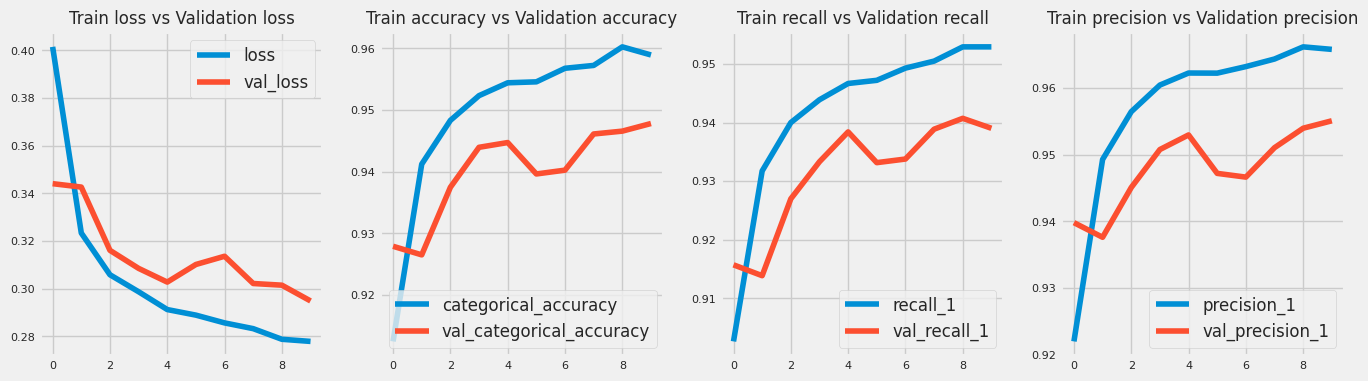

In [35]:
plotModelHistory(history_3)

## Train InceptionResNetV2 - Heavy Model

In [24]:
img_dim=299
inceptionresnet = k.applications.InceptionResNetV2(weights='imagenet', input_shape=getImgTensor(img_dim), include_top=False)
inceptionresnet.trainable = False

model_5 = k.models.Sequential([
                             inceptionresnet,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             k.layers.Dropout(0.4),
                             k.layers.Dense(256, activation='relu'),
                             k.layers.BatchNormalization(),
                             k.layers.Dropout(0.3),
                            #  k.layers.Dense(128, activation='relu'),
                            #  k.layers.BatchNormalization(),
                            #  k.layers.Dropout(0.2),
                             k.layers.Dense(3, activation='softmax')
])
print(model_5.summary())

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ ?                      │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_300         │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 54,336,736 (207.28 MB)

None


In [25]:
history_5 = trainModel(model_5, 10, 'adam', modelName='inceptionresnet')

Epoch 1/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.8691 - loss: 0.5004 - precision_2: 0.8803 - recall_2: 0.8579

2024-09-25 16:52:06.481420: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[79,1536,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[79,2080,8,8]{3,2,1,0}, f32[1536,2080,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-25 16:52:07.252644: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.771335453s
Trying algorithm eng3{k11=2} for conv (f32[79,1536,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[79,2080,8,8]{3,2,1,0}, f32[1536,2080,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_res


Epoch 1: val_loss improved from inf to 0.37221, saving model to ./inceptionresnet_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 986s 4s/step - categorical_accuracy: 0.8693 - loss: 0.5000 - precision_2: 0.8805 - recall_2: 0.8581 - val_categorical_accuracy: 0.9125 - val_loss: 0.3722 - val_precision_2: 0.9284 - val_recall_2: 0.8927 - learning_rate: 0.0010
Epoch 2/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9342 - loss: 0.3409 - precision_2: 0.9424 - recall_2: 0.9229
Epoch 2: val_loss improved from 0.37221 to 0.33955, saving model to ./inceptionresnet_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 850s 4s/step - categorical_accuracy: 0.9342 - loss: 0.3408 - precision_2: 0.9424 - recall_2: 0.9229 - val_categorical_accuracy: 0.9281 - val_loss: 0.3396 - val_precision_2: 0.9379 - val_recall_2: 0.9159 - learning_rate: 0.0010
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9412 - loss: 0.3213 - precision_2: 0.9506 - recall_2: 0.9312
Epoch 3: val_loss d

h.history:  {'categorical_accuracy': [0.9062849879264832, 0.9359157085418701, 0.9425517916679382, 0.9474902749061584, 0.949226438999176, 0.951618492603302, 0.9543963670730591, 0.9551680088043213, 0.9573286175727844, 0.9560168385505676], 'loss': [0.4089342951774597, 0.3335259258747101, 0.31899797916412354, 0.30752331018447876, 0.3036797046661377, 0.2974145710468292, 0.29217997193336487, 0.28892016410827637, 0.2867601215839386, 0.2882596254348755], 'precision_2': [0.9158609509468079, 0.9444378614425659, 0.9512224197387695, 0.9557188153266907, 0.9572629332542419, 0.9607434868812561, 0.9622344970703125, 0.9628961682319641, 0.9636940360069275, 0.9625484347343445], 'recall_2': [0.8953663110733032, 0.9253443479537964, 0.9322118759155273, 0.9384621381759644, 0.9402368664741516, 0.9432848691940308, 0.9456769227981567, 0.9471815824508667, 0.9493421912193298, 0.9489563703536987], 'val_categorical_accuracy': [0.9124864935874939, 0.9280753135681152, 0.9285383820533752, 0.9398055076599121, 0.9279209

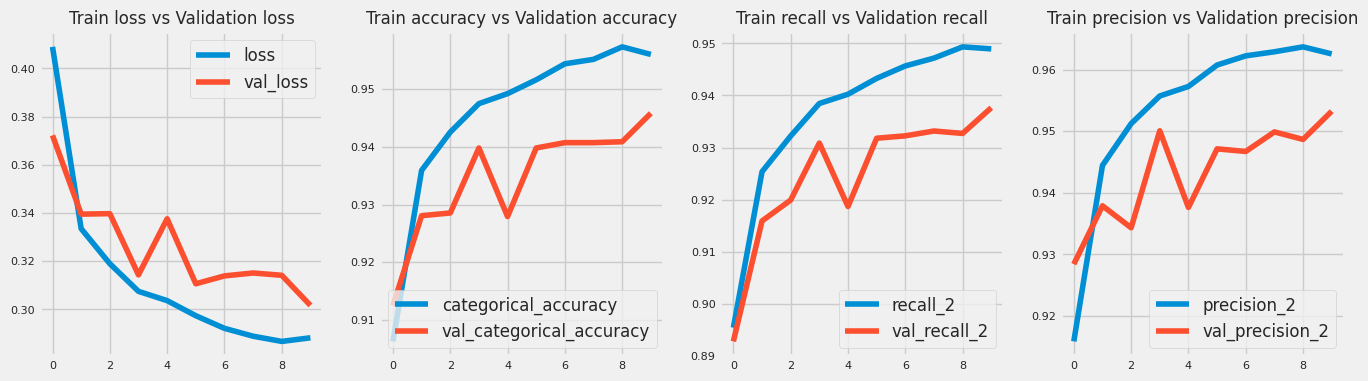

In [34]:
plotModelHistory(history_5)

## Train DenseNet169 - Light Model

In [30]:
img_dim=299
densenet152 = k.applications.DenseNet169(weights='imagenet', input_shape=getImgTensor(img_dim), include_top=False)
densenet152.trainable = False

model_6 = k.models.Sequential([
                             densenet152,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             k.layers.Dropout(0.4),
                             k.layers.Dense(256, activation='relu'),
                             k.layers.BatchNormalization(),
                             k.layers.Dropout(0.3),
                            #  k.layers.Dense(128, activation='relu'),
                            #  k.layers.BatchNormalization(),
                            #  k.layers.Dropout(0.2),
                             k.layers.Dense(3, activation='softmax')
])
print(model_6.summary())

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)        │ ?                      │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_301         │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,642,880 (48.23 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,642,880 (48.23 MB)

None


In [31]:
history_6 = trainModel(model_6, 10, 'adam', modelName='densenet169')

Epoch 1/10


2024-09-25 19:11:37.134287: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[128,128,75,75]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,192,75,75]{3,2,1,0}, f32[128,192,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-25 19:11:37.196918: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.062847874s
Trying algorithm eng3{k11=2} for conv (f32[128,128,75,75]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,192,75,75]{3,2,1,0}, f32[128,192,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.8600 - loss: 0.5351 - precision_3: 0.8718 - recall_3: 0.8486
Epoch 1: val_loss improved from inf to 0.32885, saving model to ./densenet169_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 1052s 5s/step - categorical_accuracy: 0.8603 - loss: 0.5346 - precision_3: 0.8720 - recall_3: 0.8488 - val_categorical_accuracy: 0.9378 - val_loss: 0.3289 - val_precision_3: 0.9484 - val_recall_3: 0.9307 - learning_rate: 0.0010
Epoch 2/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9417 - loss: 0.3299 - precision_3: 0.9526 - recall_3: 0.9315
Epoch 2: val_loss improved from 0.32885 to 0.30905, saving model to ./densenet169_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 823s 4s/step - categorical_accuracy: 0.9417 - loss: 0.3299 - precision_3: 0.9526 - recall_3: 0.9315 - val_categorical_accuracy: 0.9447 - val_loss: 0.3090 - val_precision_3: 0.9549 - val_recall_3: 0.9352 - learning_rate: 0.0010
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━

h.history:  {'categorical_accuracy': [0.9061306118965149, 0.9432848691940308, 0.949226438999176, 0.9542034864425659, 0.9550522565841675, 0.9588718414306641, 0.9608009457588196, 0.9634245038032532, 0.9612253308296204, 0.9631929993629456], 'loss': [0.41780805587768555, 0.3247813582420349, 0.3087325394153595, 0.2962348461151123, 0.28958362340927124, 0.2858194410800934, 0.2796356678009033, 0.2763008177280426, 0.27991655468940735, 0.27649423480033875], 'precision_3': [0.9161537289619446, 0.9526060819625854, 0.9572141766548157, 0.9614719748497009, 0.9632344245910645, 0.966044545173645, 0.9674125909805298, 0.9692752957344055, 0.9674704670906067, 0.9682056307792664], 'recall_3': [0.8958293199539185, 0.9329063892364502, 0.9391180276870728, 0.9445194602012634, 0.9481461644172668, 0.9505767822265625, 0.9540877342224121, 0.956672728061676, 0.9535475969314575, 0.9563640356063843], 'val_categorical_accuracy': [0.9377990365028381, 0.9447445869445801, 0.9530791640281677, 0.9509183764457703, 0.95477694

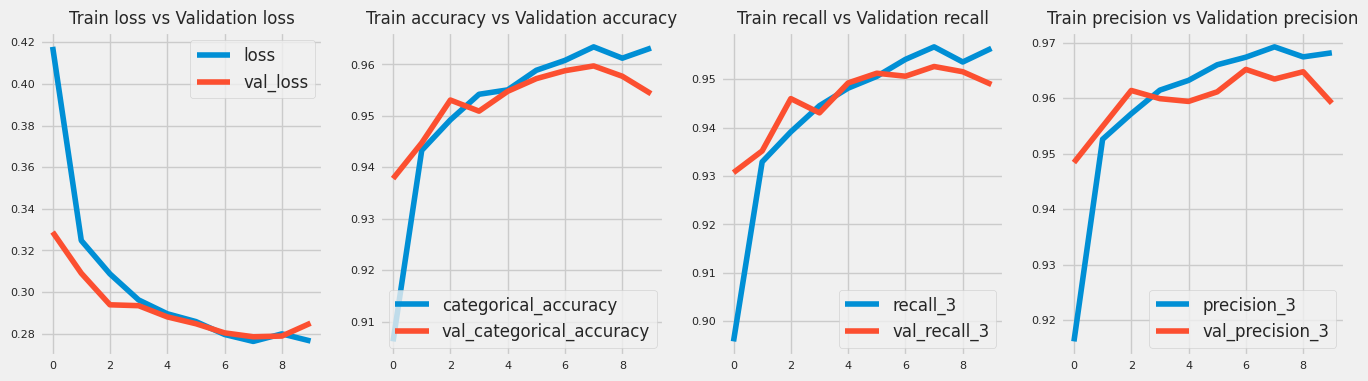

In [33]:
plotModelHistory(history_6)

# Model Evaluation

In [18]:
# mobile net
img_dim=299 
evaluateModel('/kaggle/input/mobilenet_model/keras/default/1/mobilenet_model.keras')

I0000 00:00:1727446555.302914     157 service.cc:145] XLA service 0x7eba300032b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727446555.302984     157 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/51 ━━━━━━━━━━━━━━━━━━━━ 12:59 16s/step - categorical_accuracy: 0.9688 - loss: 0.2583 - precision: 0.9685 - recall: 0.9609

I0000 00:00:1727446565.917809     157 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 251s 5s/step - categorical_accuracy: 0.9543 - loss: 0.2863 - precision: 0.9616 - recall: 0.9466

Loss: 0.2909960448741913, Accuracy: 0.9513813853263855

Precision: 0.9428924322128296, Recall: 0.9594785571098328
Prediction Time per Image: 0.04038759024170082


In [19]:
# resnet152
img_dim=299 
evaluateModel('/kaggle/input/resnet152/keras/default/1/resnet152_model.keras')

51/51 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - categorical_accuracy: 0.9615 - loss: 0.2585 - precision: 0.9650 - recall: 0.9587

Loss: 0.26611125469207764, Accuracy: 0.9557030200958252

Precision: 0.9524617791175842, Recall: 0.960616409778595
Prediction Time per Image: 0.04050325052037911


In [20]:
# inceptionv3
img_dim=299 
evaluateModel('/kaggle/input/inceptionv3/keras/default/1/inceptionv3_model.keras')

51/51 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - categorical_accuracy: 0.9446 - loss: 0.2945 - precision_1: 0.9527 - recall_1: 0.9348

Loss: 0.2967461943626404, Accuracy: 0.9444358944892883

Precision: 0.9348664879798889, Recall: 0.9517598748207092
Prediction Time per Image: 0.033506982652911764


In [21]:
# inceptionresnet
img_dim=299 
evaluateModel('/kaggle/input/inceptionresnet/keras/default/1/inceptionresnet_model.keras')

51/51 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - categorical_accuracy: 0.9431 - loss: 0.3023 - precision_2: 0.9516 - recall_2: 0.9356

Loss: 0.30261456966400146, Accuracy: 0.9430467486381531

Precision: 0.9350208640098572, Recall: 0.9520666599273682
Prediction Time per Image: 0.03937992859740448


In [24]:
# densenet169
img_dim=299 
evaluateModel('/kaggle/input/densenet/keras/default/1/densenet169_model.keras')

51/51 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - categorical_accuracy: 0.9561 - loss: 0.2789 - precision_3: 0.9616 - recall_3: 0.9475

Loss: 0.2784791588783264, Accuracy: 0.9574008584022522

Precision: 0.949529230594635, Recall: 0.9626036882400513
Prediction Time per Image: 0.039129002886544154


# Model Prediction

In [83]:
# mobile net
img_dim=299 
evaluateModelWithTestData('/kaggle/input/mobilenet_model/keras/default/1/mobilenet_model.keras')

10500/10500 ━━━━━━━━━━━━━━━━━━━━ 117s 11ms/step - categorical_accuracy: 0.9687 - loss: 0.2460 - precision: 0.9750 - recall: 0.9657

Loss: 0.27806681394577026, Accuracy: 0.9582856893539429

Precision: 0.952571451663971, Recall: 0.9656304121017456
Prediction Time per Image: 0.011337097871871222


In [84]:
# resnet152
img_dim=299 
evaluateModelWithTestData('/kaggle/input/resnet152/keras/default/1/resnet152_model.keras')

10500/10500 ━━━━━━━━━━━━━━━━━━━━ 305s 28ms/step - categorical_accuracy: 0.9741 - loss: 0.2326 - precision: 0.9773 - recall: 0.9709

Loss: 0.2374601662158966, Accuracy: 0.9721904993057251

Precision: 0.9694285988807678, Recall: 0.9755606651306152
Prediction Time per Image: 0.03597066799799601


In [85]:
# inceptionv3
img_dim=224 
evaluateModelWithTestData('/kaggle/input/inceptionv3/keras/default/1/inceptionv3_model.keras')

10500/10500 ━━━━━━━━━━━━━━━━━━━━ 179s 17ms/step - categorical_accuracy: 0.9632 - loss: 0.2676 - precision_1: 0.9701 - recall_1: 0.9556

Loss: 0.2824644148349762, Accuracy: 0.9586666822433472

Precision: 0.94990473985672, Recall: 0.9650701284408569
Prediction Time per Image: 0.018115545023055304


In [86]:
# inceptionresnet
img_dim=299 
evaluateModelWithTestData('/kaggle/input/inceptionresnet/keras/default/1/inceptionresnet_model.keras')

10500/10500 ━━━━━━━━━━━━━━━━━━━━ 383s 35ms/step - categorical_accuracy: 0.9652 - loss: 0.2667 - precision_2: 0.9698 - recall_2: 0.9582

Loss: 0.2814069092273712, Accuracy: 0.9588571190834045

Precision: 0.952571451663971, Recall: 0.9633054137229919
Prediction Time per Image: 0.040927539008004325


In [87]:
# densenet169
img_dim=299 
evaluateModelWithTestData('/kaggle/input/densenet/keras/default/1/densenet169_model.keras')

10500/10500 ━━━━━━━━━━━━━━━━━━━━ 246s 22ms/step - categorical_accuracy: 0.9716 - loss: 0.2563 - precision_3: 0.9744 - recall_3: 0.9664

Loss: 0.2604067623615265, Accuracy: 0.9713333249092102

Precision: 0.9660000205039978, Recall: 0.9753822684288025
Prediction Time per Image: 0.02487455958411807


# Sample Test

In [88]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

classToLabel = {0: 'Smoke', 1: 'fire', 2: 'non fire'}

model = '/kaggle/input/densenet/keras/default/1/densenet169_model.keras'
sampleImgPath = '/kaggle/input/forest-fire-and-non-fire-dataset/test/fire/Fire (1006).jpg'
# sampleImgPath = '/kaggle/input/forest-fire-and-non-fire-dataset/test/non fire/09363.jpg'

img_width = 299
img_height = 299

# predicting images
def predictOutput(model, path=True):
    img = image.load_img(sampleImgPath, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    if path and sampleImgPath:
        model = k.models.load_model(model)
        images = np.vstack([x])
        eval_results = np.argmax(model.predict(x),axis=1)
        print(classToLabel[eval_results[0]])

predictOutput(model, sampleImgPath)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
fire
